## DrivenData Richter's Predictor
The dataset comes from the DrivenData challenge "Richter's Predictor: Modeling Earthquake Damage" where the goal of the challenge is to predict the damage grade after an earthquake for a particular location in Nepal based on a collection of features represented in the data.
The objective of this notebook was to explore a few different tree-based models, as well as test out an implementation of Bayesian Hyperparameter Optimization.


In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb

from imblearn.over_sampling import SMOTENC

import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization, UtilityFunction

import numpy as np

In [2]:
train_labels = pd.read_csv("data/train_labels.csv")
test = pd.read_csv("data/test_values.csv")
df = pd.read_csv("data/train_values.csv")
print("N in test set is {}".format(len(test)))
print("N in training set is {}".format(len(df)))
# Total N is about 347,000, could consider a validation set of size 70k which is about 20% of total N

N in test set is 86868
N in training set is 260601


### Data Exploration
Loading in the data and looking at feature types and distributions

array([[<Axes: title={'center': 'damage_grade'}>]], dtype=object)

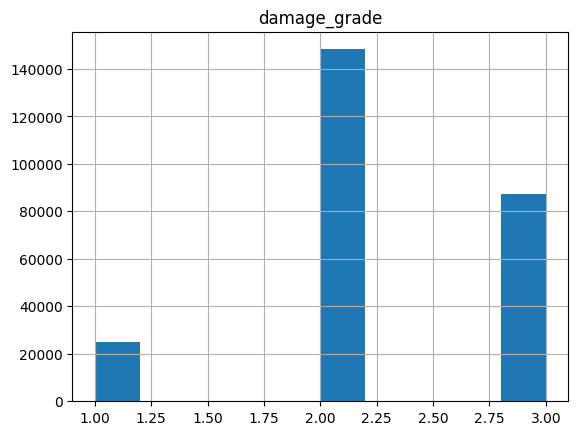

In [3]:
# View distribution of target variable, it appears imbalanced
train_labels.hist('damage_grade')

In [4]:
# Check for null values
df.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

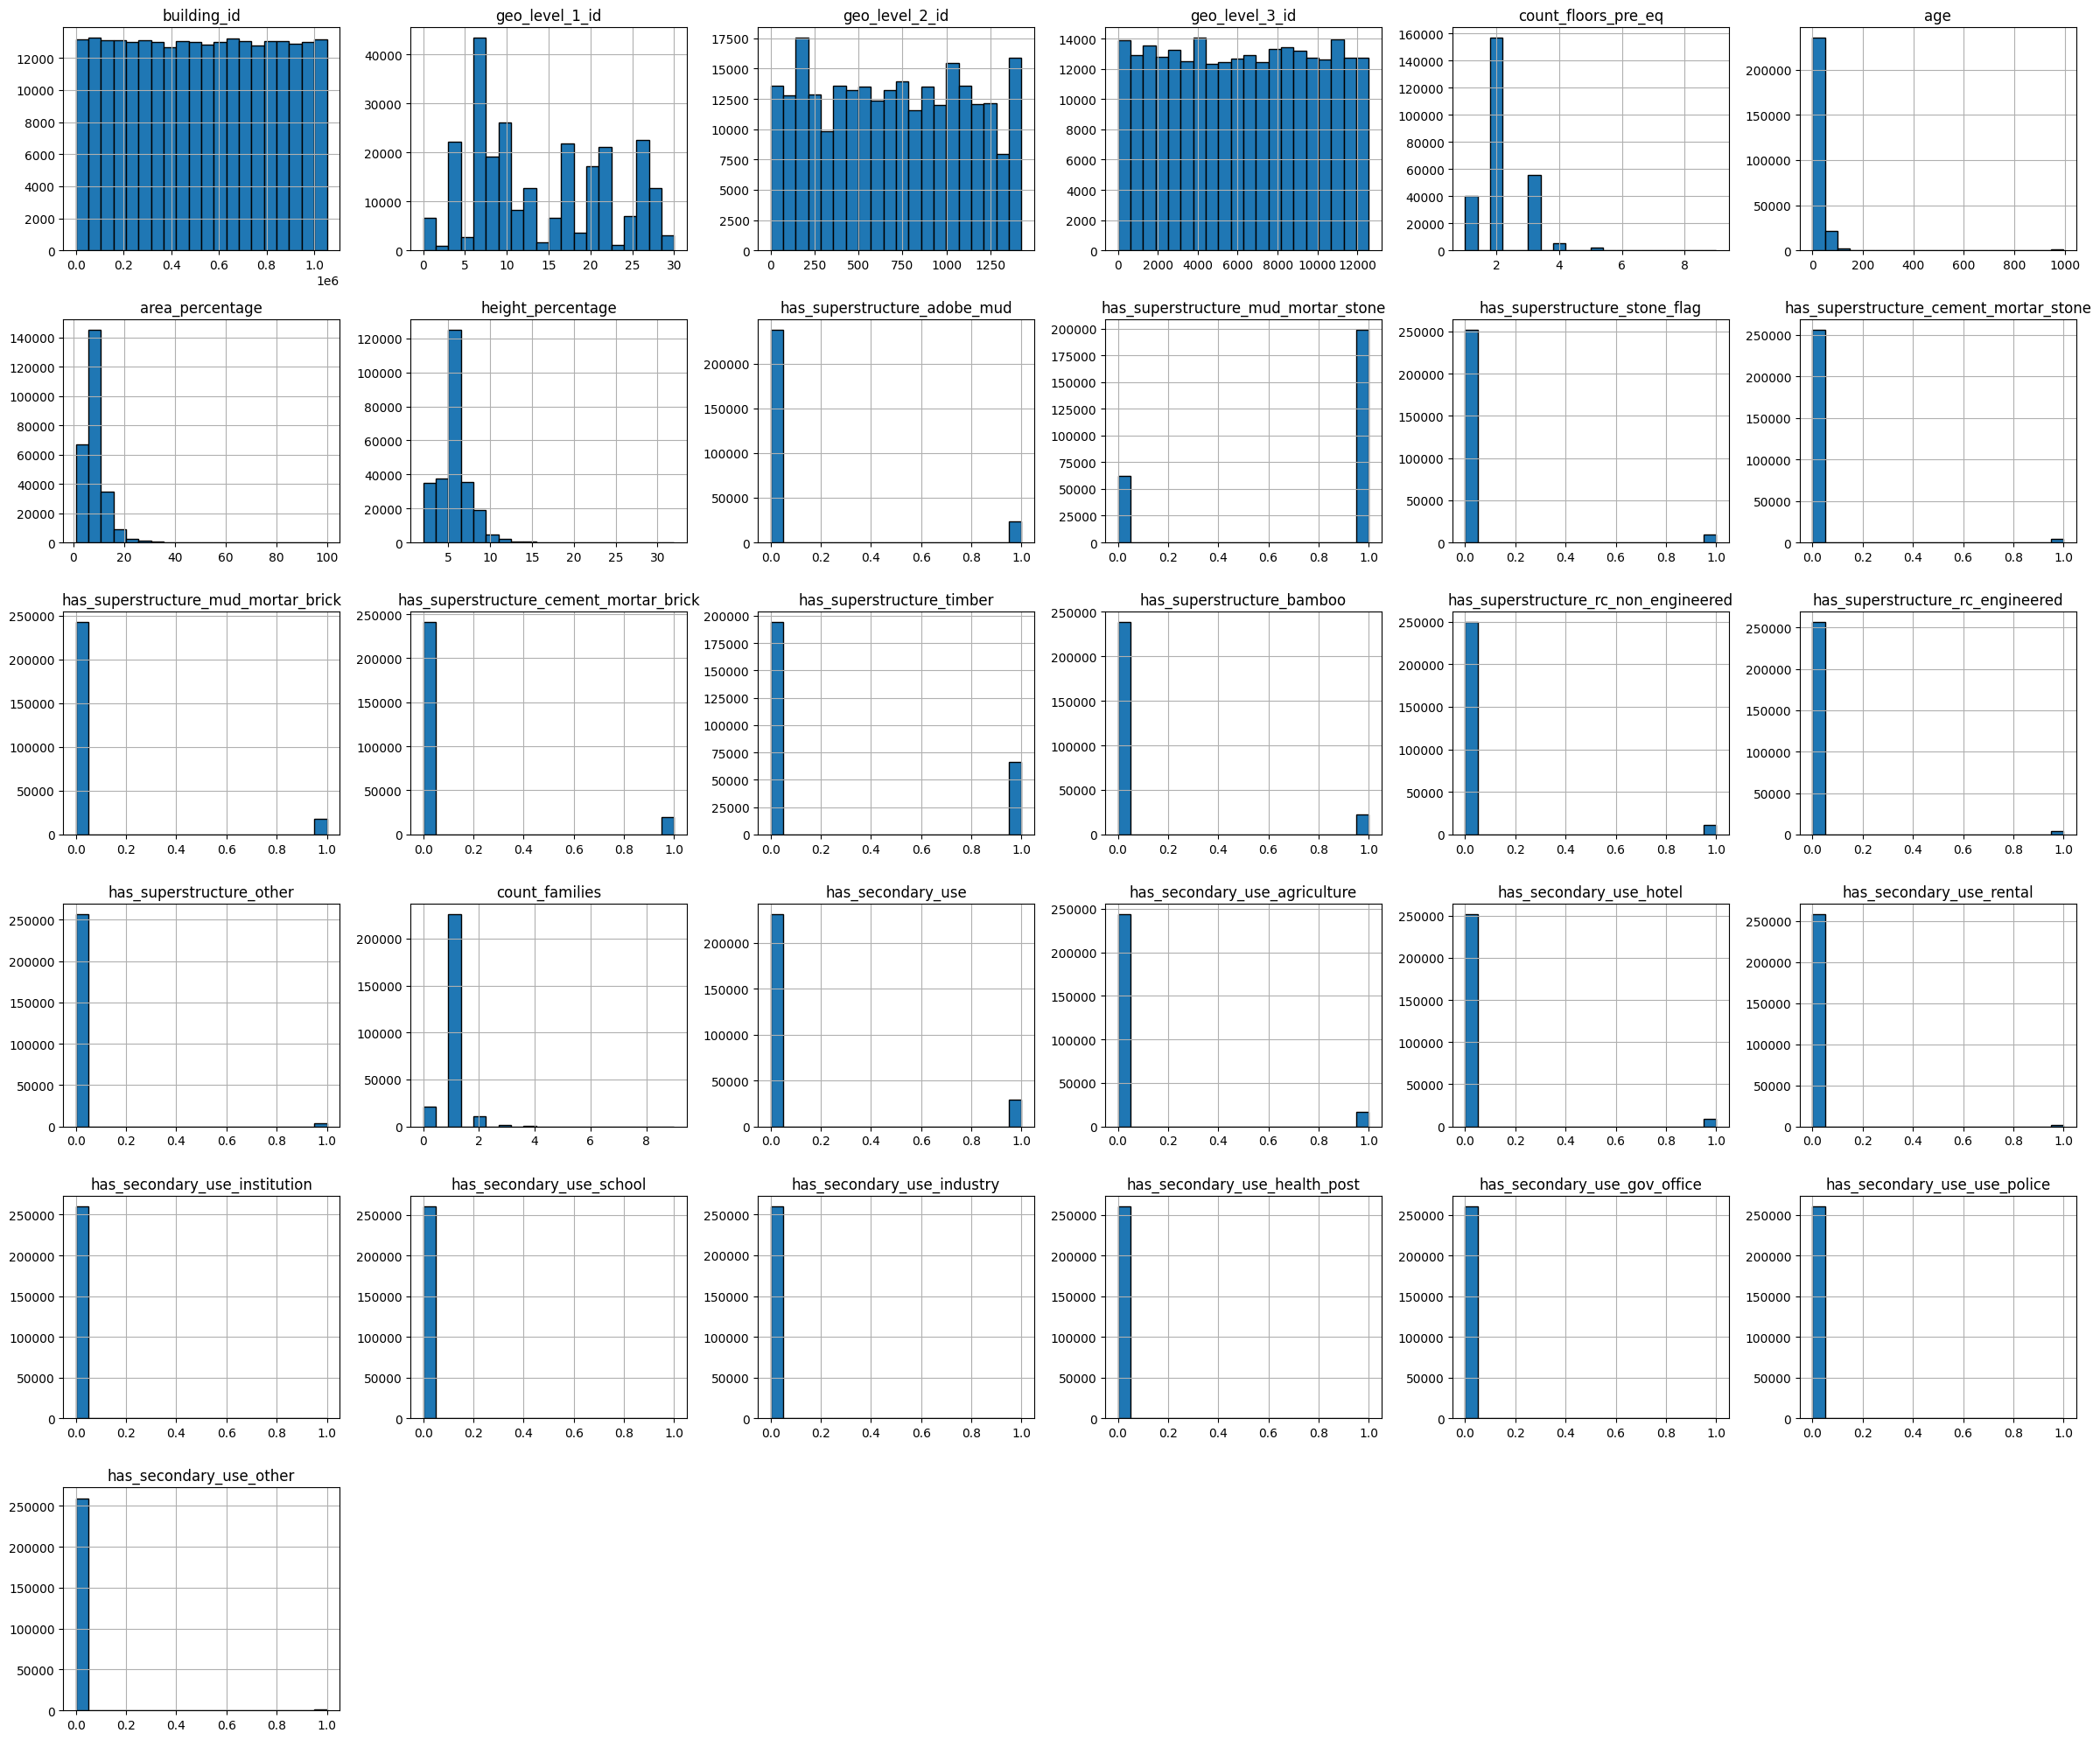

In [11]:
# View distribution of numeric/binary variables
df.hist(figsize=(24, 20), bins=20, edgecolor='black')

plt.tight_layout()
plt.show()

In [35]:
nonnum_cols = []
for col in df.columns:
    if isinstance(df[col][0], str):
        nonnum_cols.append(col)

In [34]:
for col in nonnum_cols:
    print("{} unique values are {}".format(col, df[col].unique()))

land_surface_condition unique values are ['t' 'o' 'n']
foundation_type unique values are ['r' 'w' 'i' 'u' 'h']
roof_type unique values are ['n' 'q' 'x']
ground_floor_type unique values are ['f' 'x' 'v' 'z' 'm']
other_floor_type unique values are ['q' 'x' 'j' 's']
position unique values are ['t' 's' 'j' 'o']
plan_configuration unique values are ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
legal_ownership_status unique values are ['v' 'a' 'r' 'w']


### Feature Engineering
I chose to one-hot encode the categorical variables and use an oversampling technique to attempt to create better accuracy numbers for the minority class.

In [36]:
# Joining in the target values, dropping the unique building identifier, and 
# identifying numeric columns
df = df.join(train_labels, rsuffix="r")
df = df.drop(["building_idr", "building_id"], axis=1)
num_cols = df.describe().columns

In [37]:
# Create dummy variables for categorical columns
df_ohc = pd.get_dummies(df[nonnum_cols])

In [38]:
y = df["damage_grade"]

X = pd.concat([df[num_cols], df_ohc], axis=1)

# Identifying all categorical columns for sampling analysis
cat_cols = list(range(len(num_cols),68))
X = X.drop(["damage_grade"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<Axes: >

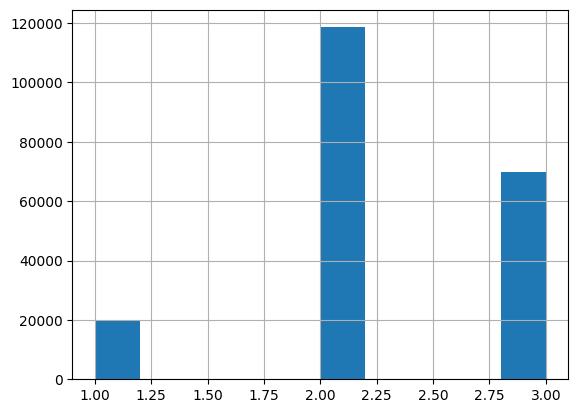

In [39]:
y_train.hist()

In [44]:
# Because the target variable appears imbalanced, I'd like to see if using an oversampling 
# method will improve accuracy score. I use SMOTENC to oversample this dataset that contains 
# both categorical and numeric values
sm = SMOTENC(categorical_features=cat_cols, random_state=123, sampling_strategy='minority')
X_trainres, y_trainres = sm.fit_resample(X_train, y_train)

<Axes: >

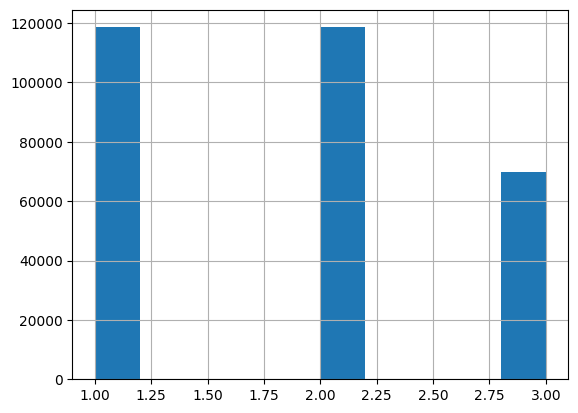

In [45]:
# The new y_trainres distribution looks more balanced
y_trainres.hist()

### Model Creation
Fit and evaluate decision tree, random forest and XGBoost models

In [42]:
def evaluate_model(y_test, y_pred):
    '''
    Print the F1 score and confusion matrix for the input y_test and y_pred series
    '''
    print(f"F1 Score: {f1_score(y_test, y_pred.round(), average='micro')}")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

In [41]:
def evaluate_decision_tree(x_train, y_train, x_test, y_test):
    '''
    Create a decision tree and fit it to the training data. Predict target
    values based on testing data and evaluate those predicions against the 
    test data
    '''
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(x_train, y_train)

    y_pred_dt = clf.predict(x_test)

    evaluate_model(y_test, y_pred_dt)

In [46]:
evaluate_decision_tree(X_train, y_train, X_test, y_test)
evaluate_decision_tree(X_trainres, y_trainres, X_test, y_test)
# Appears that the oversampled gives higher accuracy for minority class, but lowers F1 score by a bit

F1 Score: 0.6582183764701368
Confusion Matrix
[[ 2525  2183   317]
 [ 2379 20951  6322]
 [  342  6271 10831]]
F1 Score: 0.6580073290995951
Confusion Matrix
[[ 2562  2163   300]
 [ 2441 20863  6348]
 [  363  6210 10871]]


In [49]:
def eval_random_forest(x_train, y_train, x_test, y_test):
    '''
    Create a random forest and fit it to the training data. Predict target
    values based on testing data and evaluate those predicions against the 
    test data
    '''
    regr = RandomForestRegressor(n_estimators=100, random_state=42)
    regr.fit(x_train, y_train)
    print("done fitting")
    
    y_pred = regr.predict(x_test)
    evaluate_model(y_test, y_pred.round())

In [50]:
eval_random_forest(X_train, y_train, X_test, y_test)
eval_random_forest(X_trainres, y_trainres, X_test, y_test)
# Oversampled data still underperforms in F1 but gives higher accuracy for minority class

done fitting
F1 Score: 0.7267512135223806
Confusion Matrix
[[ 2300  2662    63]
 [ 1101 24534  4017]
 [   80  6319 11045]]
done fitting
F1 Score: 0.7257343489188619
Confusion Matrix
[[ 2344  2611    70]
 [ 1138 24488  4026]
 [   81  6369 10994]]


In [51]:
# Adjust target values to start at 0 for XGBoost
y_test_xg = y_test-1
y_train_xg = y_train-1
y_trainres_xg = y_trainres - 1

In [53]:
def run_xgboost(X_train, X_test, y_train_xg, y_test_xg, param=None):
    '''
    Create and train an XGBoost model using the passed training/testing data 
    and dictionary of parameters.'''
    # Convert the dataset into a data structure called Dmatrix that XGBoost supports
    D_train = xgb.DMatrix(X_train, label=y_train_xg)
    D_test = xgb.DMatrix(X_test, label=y_test_xg)

    if not param: 
        param = {
        'objective': 'multi:softprob',  
        'num_class': 3}

    steps = 100  # The number of training iterations

    # Train 
    model = xgb.train(param, D_train, steps, num_boost_round=95)
    print("trained model")
    # Predict 
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    return (model, best_preds)

In [55]:
xg_model, best_preds_xg = run_xgboost(X_train, X_test, y_train_xg, y_test_xg)
evaluate_model(y_test_xg, best_preds_xg.round())
xg_model_res, best_preds_xg_res = run_xgboost(X_trainres, X_test, y_trainres_xg, y_test_xg)
evaluate_model(y_test_xg, best_preds_xg_res.round())


trained model
F1 Score: 0.7270198192667063
Confusion Matrix
[[ 2303  2663    59]
 [  992 25229  3431]
 [   74  7009 10361]]
trained model
F1 Score: 0.7245448091939909
Confusion Matrix
[[ 2287  2681    57]
 [  980 25309  3363]
 [   70  7206 10168]]


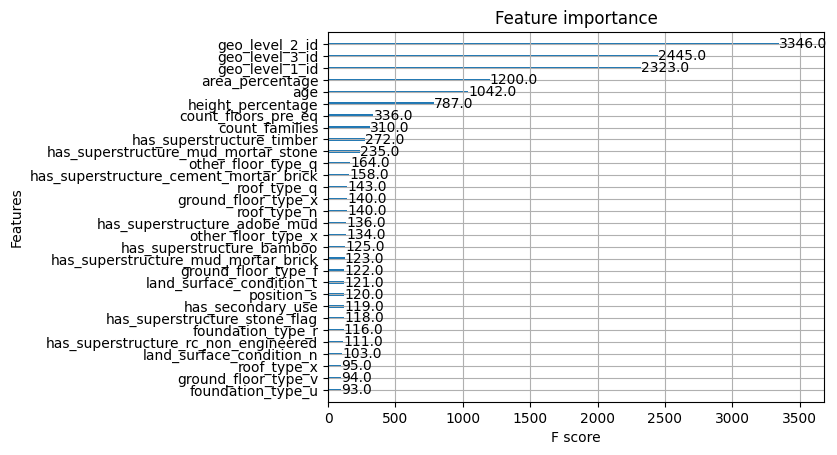

<Figure size 1600x1200 with 0 Axes>

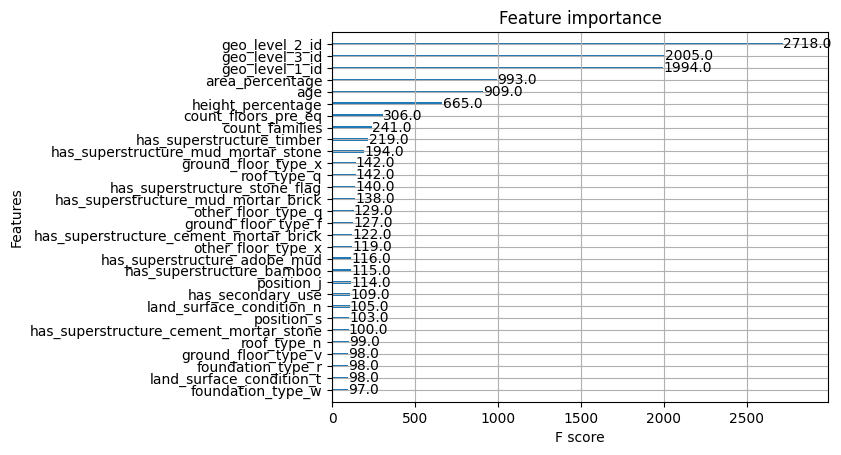

<Figure size 1600x1200 with 0 Axes>

In [58]:
# Plotting feature importance for the models fit on original training data
# and oversampled data
for model in [xg_model, xg_model_res]:
    xgb.plot_importance(model, max_num_features=30)
    plt.figure(figsize = (16, 12))
    plt.show()

Plotting feature importance indicates to me that in the future it would be valuable to look into techniques that could extract more information from the top 6 features from the charts above.

### Bayesian Hyperparameter Optimization
Rather than trying out a simple grid search algorithm for hyperparameter tuning. I'd like to try a bayesian optimization method. A BO method should increase efficiency of the algorithm as it bases its next selection of hyperparameters off of the performance of pervious parameters.

In [75]:
len(y_train)

208480

In [76]:
# create validation sets for tuning
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size=0.2, 
                                                      random_state=42, 
                                                      stratify=y_train)

In [86]:
# We start by defining the score we want to be maximized using Bayesian Optimization (F1 score)

seed = 42 # Random seed

def xgbc(max_depth, eta, n_estimators, reg_alpha):
    ''' 
    Returns the F1 score of an XGBoost classifier created with the 
    parameters passed in.
    Inputs:
        max_depth: maximum depth of any tree in the model (int)
        eta: learning rate (float)
        n_estimators: number of trees (int)
        reg_alpha: L1 regularization term (float)
    Returns:
        val_f1: F1 score (float)
    '''
    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           eta= eta,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='multi:softmax',
                                           seed = seed)

    estimator_function.fit(X_val,y_val-1)
    preds = estimator_function.predict(X_test)
    val_f1 = f1_score(y_test_xg, preds, average='micro')

    return val_f1


In [87]:
# alpha is a parameter for the gaussian process (could also be optimized)
gp_params = {"alpha": 1e-10}
seed = 42 # Random seed

# Create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
hyperparameter_space = {
    'max_depth': (3, 12),
    'eta': (0, 1),
    'n_estimators' : (1,50),
    'reg_alpha': (0,1),
}

xgbcBO = BayesianOptimization(f = xgbc, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)
 
acq_func = UtilityFunction('ucb') # "upper confidence bound", there are other options
xgbcBO.set_gp_params(**gp_params)
xgbcBO.maximize(init_points=3, n_iter=10, acquisition_function=acq_func)

|   iter    |  target   |    eta    | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
| 1         | 0.7141    | 0.3745    | 11.56     | 36.87     | 0.5987    |
| 2         | 0.6523    | 0.156     | 4.404     | 3.846     | 0.8662    |
| 3         | 0.69      | 0.6011    | 9.373     | 2.009     | 0.9699    |
| 4         | 0.7149    | 0.2397    | 11.51     | 37.02     | 0.6401    |
| 5         | 0.707     | 0.7455    | 12.0      | 44.14     | 0.7738    |
| 6         | 0.09641   | 0.0       | 4.435     | 39.23     | 1.0       |
| 7         | 0.7021    | 1.0       | 12.0      | 10.04     | 0.6031    |
| 8         | 0.09641   | 0.0       | 5.264     | 14.71     | 0.0       |
| 9         | 0.6974    | 1.0       | 12.0      | 50.0      | 0.0       |
| 10        | 0.09641   | 0.0       | 12.0      | 28.4      | 1.0       |
| 11        | 0.7071    | 1.0       | 5.149     | 50.0      | 0.0       |
| 12        | 0.6946    | 1.0       | 

In [80]:
# Take best parameter space from Bayesian Opt and train model
best_params = {
        'objective': 'multi:softprob',  
        'num_class': 3,
        'n_estimators':37,
        'alpha':0.6401,
        'eta':0.2397,
        'max_depth':12
    } 
xg_model_t, best_preds_xg_t = run_xgboost(X_train, X_test, y_train_xg, y_test_xg, best_params)
evaluate_model(y_test_xg, best_preds_xg_t.round())
xg_model_res_t, best_preds_xg_res_t = run_xgboost(X_trainres, X_test, y_trainres_xg, y_test_xg, best_params)
evaluate_model(y_test_xg, best_preds_xg_res_t.round())
# Promising to see an increased F1 score through hyperparameter tuning on a validation set.

trained model
F1 Score: 0.7439995395330097
Confusion Matrix
[[ 2634  2323    68]
 [ 1167 24986  3499]
 [  120  6166 11158]]
trained model
F1 Score: 0.7436350031657105
Confusion Matrix
[[ 2664  2298    63]
 [ 1165 25079  3408]
 [   99  6329 11016]]


### Predictions and dataframe creation

In [83]:
def create_dataframe(building_ids, preds):
    '''
    Create a dataframe using building_ids and preds parameters. 
    Returns a pandas dataframe object
    '''
    df = pd.DataFrame([building_ids, preds.round().astype(int)]).transpose()
    df = df.rename(columns={"Unnamed 0":"damage_grade"})
    return df

In [82]:
test_proc = pd.get_dummies(test)
test_proc = test_proc.drop("building_id", axis=1)
D_test_final = xgb.DMatrix(test_proc)
preds = xg_model_t.predict(D_test_final)

In [84]:
xg_df = create_dataframe(test['building_id'],np.argmax(preds, axis=1)+1)
xg_df.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,2
4,421793,3


In [85]:
xg_df.to_csv("drivenDataPreds.csv", index=False)